In [369]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [370]:
# Carga de datos
calculo_de_flujos  = pd.read_pickle(r'Pagos_beneficio_mensuales.pickle')
rendimientos = pd.read_excel("TasaRendimientoActuarial.xlsx",sheet_name='Nueva Metodología',header=6)
rendimientos = rendimientos[['Período','Activo Neto- Valor de Mercado','Cotizaciones Netas ','Pago de Pensiones']] # Variables de interes
rendimientos=rendimientos[rendimientos['Período']<'2022-07-01'] # periodo a utilizar para proyeccion

In [371]:
Activo_lagueado = np.append(np.nan,[rendimientos['Activo Neto- Valor de Mercado'][x] for x in range(0,len(rendimientos['Cotizaciones Netas ']) -1) ]) # Columna de activo pasado

In [375]:
rendimientos['Activo_lagueado'] = Activo_lagueado

Supuesto: Se asume que el pago de pensión se hizo a mitad del mes y que se recibió la cotización a mitad del mes, por ende, solo tuvieron rendimientos de medio mes.

In [376]:
rendimientos['tasa_rendimiento'] = 2*(rendimientos['Activo Neto- Valor de Mercado'] - rendimientos['Activo_lagueado'] -  rendimientos['Cotizaciones Netas ']  + rendimientos['Pago de Pensiones'])/(2*rendimientos['Activo_lagueado'] +  rendimientos['Cotizaciones Netas ']  - rendimientos['Pago de Pensiones'])

(array([ 1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1., 10., 10.,
        28., 24.,  6.,  9.,  6.,  5.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  1.]),
 array([-0.01200954, -0.0106422 , -0.00927486, -0.00790752, -0.00654018,
        -0.00517284, -0.0038055 , -0.00243817, -0.00107083,  0.00029651,
         0.00166385,  0.00303119,  0.00439853,  0.00576587,  0.00713321,
         0.00850055,  0.00986789,  0.01123523,  0.01260257,  0.01396991,
         0.01533724,  0.01670458,  0.01807192,  0.01943926,  0.0208066 ,
         0.02217394,  0.02354128,  0.02490862,  0.02627596,  0.0276433 ,
         0.02901064]),
 <a list of 30 Patch objects>)

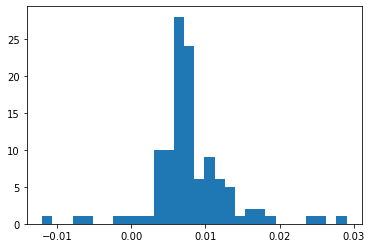

In [377]:
plt.hist(rendimientos['tasa_rendimiento'], bins=30)

In [378]:
rendimientos.describe()

,Activo Neto- Valor de Mercado,Cotizaciones Netas,Pago de Pensiones,Activo_lagueado,tasa_rendimiento
count,1.150000e+02,114.000000,114.000000,1.140000e+02,114.000000
mean,2.190636e+06,12613.402788,681.757567,2.173193e+06,0.007848
std,9.568622e+05,7892.579983,533.544863,9.425432e+05,0.005262
min,8.879092e+05,-55787.844227,144.107466,8.879092e+05,-0.012010
25%,1.328260e+06,9870.054809,263.499652,1.321949e+06,0.005985
50%,2.019179e+06,12698.270085,470.322317,2.013215e+06,0.007145
75%,3.053615e+06,15690.429102,993.364140,3.017601e+06,0.009800
max,4.179158e+06,28356.051802,2117.126675,4.093028e+06,0.029011


In [379]:
# Estimación pésima de rendimientos que me doy verguenza a mi mismo pero no puedo hacer nada más porque no hay información:
rendimiento_esperado = rendimientos.tasa_rendimiento.mean()

In [380]:
seguridad_de_estimador = [rendimientos.tasa_rendimiento.sample(115,replace=True).mean() for k in range(1000)]
[2*rendimiento_esperado - np.quantile(seguridad_de_estimador,1-0.05/2) ,2*rendimiento_esperado - np.quantile(seguridad_de_estimador,0.05/2)  ]

[0.006832851396309601, 0.008784940349589626]

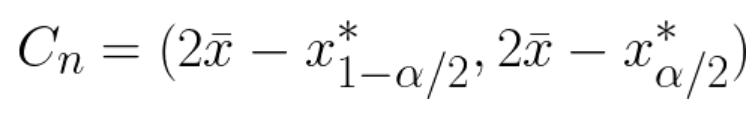

## Cálculo de flujos

In [381]:
min_date = np.datetime64('2012-12')
mid_date = np.datetime64('2022-06') 
max_date = mid_date+  np.timedelta64(len(calculo_de_flujos), 'M')
periodo_1 = pd.period_range(min_date, mid_date, freq='M')
periodo_2 = pd.period_range(mid_date+  np.timedelta64(1, 'M'), max_date, freq='M')

In [382]:
rendimientos['Período'] = periodo_1

In [383]:
for k in range(len(calculo_de_flujos)):
    nuevo_activo = rendimientos.iloc[-1,1]*(1+rendimiento_esperado) + 0*(1+rendimiento_esperado/2) - calculo_de_flujos[k]/1000000*(1+rendimiento_esperado/2)
    aux = pd.DataFrame({'X1':[periodo_2[k]],'X2': [nuevo_activo], 'X3': [0],'X4':[calculo_de_flujos[k]/1000000],'X5':[rendimientos.iloc[-1,1]],'X6':[rendimiento_esperado]})
    aux.columns = rendimientos.columns
    rendimientos = pd.concat([rendimientos,aux],ignore_index=True)
    

In [405]:
rendimientos

,Período,Activo Neto- Valor de Mercado,Cotizaciones Netas,Pago de Pensiones,Activo_lagueado,tasa_rendimiento
0,2012-12,8.879092e+05,NaN,NaN,NaN,NaN
1,2013-01,9.236808e+05,10027.416776,157.856132,8.879092e+05,0.029011
2,2013-02,9.414241e+05,4737.158978,144.107466,9.236808e+05,0.014202
3,2013-03,9.618599e+05,10334.929122,152.469575,9.414241e+05,0.010833
4,2013-04,9.155842e+05,-55787.844227,157.747894,9.618599e+05,0.010354
...,...,...,...,...,...,...
1490,2137-02,1.855877e+11,0.000000,0.000000,1.841425e+11,0.007848
1491,2137-03,1.870442e+11,0.000000,0.000000,1.855877e+11,0.007848
1492,2137-04,1.885122e+11,0.000000,0.000000,1.870442e+11,0.007848
1493,2137-05,1.899916e+11,0.000000,0.000000,1.885122e+11,0.007848


In [396]:
4.179158e+06 * 1000000 / 303166955286 # Activo actuarial/Pasivo actuarial

13.785005018299202

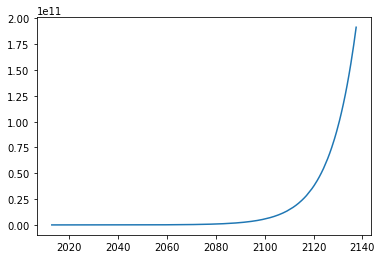

In [402]:
pd.plotting.register_matplotlib_converters()
plt.plot(rendimientos['Período'].dt.to_timestamp(),rendimientos['Activo Neto- Valor de Mercado'])